### Assignment 1

- Data Set Choose: Reviews of Musical Instrument
- The following data Musical Instrument is from http://jmcauley.ucsd.edu/data/amazon/

In [2]:
# Data Loading
import pandas as pd
import numpy as np
import gzip
import re
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import ngrams
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np
import json

import warnings
warnings.filterwarnings('ignore') 


stemmer = PorterStemmer()

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Musical_Instruments_5.json.gz')
# print(len(df.overall))
# print(df.reviewText)


#### Classification Method 1: 
- Like binary classification, the approach can be extended to multiclass classification

In [9]:
# Data Preprocessing
# part of the code inspired by : https://github.com/Jcharis/Natural-Language-Processing-Tutorials/blob/master/Text%20Classification%20With%20Machine%20Learning,SpaCy,Sklearn(Sentiment%20Analysis)/Text%20Classification%20&%20Sentiment%20Analysis%20with%20SpaCy,Sklearn.ipynb

def scorePreprocessor(score):
    # 1  -> positive 
    # -1 -> negative
    # 0  -> neutral 
    res = []
    for i in range(len(score)):
        if score[i] >= 3:
            res.append(1)
        else:
            res.append(0)
    return res
    

#https://www.kaggle.com/chewzy/benchmark-exercise-using-naive-bayes-classifier
def neg_tag(text):
    
    """
    Input is string (e.g. I am not happy.)
    Output is string with neg tags (e.g. I am not NOT_happy.)
    """
    # \b匹配边界 即单词的位置 \w匹配的是单词的范围 \s 匹配空格 +前面的匹配1次到多次
    
    transformed = re.sub(r"\b(?:never|nothing|nowhere|noone|none|not|haven't|hasn't|hasnt|hadn't|hadnt|can't|cant|couldn't|couldnt|shouldn't|shouldnt|won't|wont|wouldn't|wouldnt|don't|dont|doesn't|doesnt|didn't|didnt|isnt|isn't|aren't|arent|aint|ain't|hardly|seldom)\b[\w\s]+[^\w\s]", lambda match: re.sub(r'(\s+)(\w+)', r'\1NOT_\2', match.group(0)), text, flags=re.IGNORECASE)
    return(transformed)
       


    
def preprocessing_neg_tag(list_of_sentences):
    
    """
    Input is list of raw sentences.
    Output is list of neg-tagged and processed sentences.
    Used for preprocessing method N1, N2, N3
    """
    
    processed_sentences = []
    
    #参考了 https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908
    for sent in list_of_sentences:
        
        processed = sent.lower()
        # remove number 
        rmNum = re.sub(r'\d+', '', processed)
        # remove punc
        afterNeg = neg_tag(rmNum)
        result = afterNeg.translate(str.maketrans('', '', string.punctuation))
        processed_sentences.append(result)


    if len(processed_sentences) == len(list_of_sentences):
        return processed_sentences
    else:
        print('Length of processed is different from input')


def vectorizer(X_train, X_test, N, featurerange):
    '''
    input should be sentences
    >>> from sklearn.feature_extraction.text import TfidfVectorizer
    >>> corpus = [
    ...     'This is the first document.',
    ...     'This document is the second document.',
    ...     'And this is the third one.',
    ...     'Is this the first document?',
    ... ]
    >>> vectorizer = TfidfVectorizer()
    >>> X = vectorizer.fit_transform(corpus)
    >>> print(vectorizer.get_feature_names())
    ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
    >>> print(X.shape)
    (4, 9)
    '''
    
    # Instantiate the vectorizer
    word_vectorizer = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{2,}',  #vectorize 2-character words or more
    ngram_range=(1, N),
    max_features=featurerange)

    # fit and transform on it the training features
    word_vectorizer.fit(X_train)
    X_train_word_features = word_vectorizer.transform(X_train)
    #transform the test features to sparse matrix
    test_features = word_vectorizer.transform(X_test)

    return X_train_word_features, test_features

def build_models(x_train, y_train, x_test, y_test):
    
    mnb = MultinomialNB()
    mnb.fit(x_train,y_train)
    
    model_list = []
    r = {}
    #r['features'] = features
    r['train_acc'], r['test_acc'], r['train_f1'], r['test_f1'], r['tr_cf'] , r['te_cf'], _, _ = get_train_test_score(mnb,
                                                                                                                     x_train, 
                                                                                                                     x_test, 
                                                                                                                     y_train, 
                                                                                                                     y_test)
    model_list.append(r)
    
    return model_list
    
    
def get_train_test_score(model, x_train, x_test, y_train, y_test):
    
    """
    Function to get train and test score
    """
    
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
# 

    
    train_acc = accuracy_score(y_train,y_train_pred)
    test_acc = accuracy_score(y_test,y_test_pred)
    
    train_f1 = f1_score(y_train,y_train_pred,average='weighted')
    test_f1 = f1_score(y_test,y_test_pred,average='weighted')
    
    train_cf = confusion_matrix(y_train,y_train_pred)
    test_cf = confusion_matrix(y_test,y_test_pred)
    
    train_acc, test_acc, train_f1, test_f1 = [round(x*100,1) for x in [train_acc, test_acc, train_f1, test_f1]]
    
    return train_acc, test_acc, train_f1, test_f1, train_cf, test_cf, y_train_pred, y_test_pred


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Obtained from sklearn documentations.
    
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plotandprintResult(model_list, ngram, feature):
    print('It is 1~',ngram)
    print('and feature is ',feature)
    print('===============================================================================================================================\n')
    print('Current Model Training Accuracy\t: {} %'.format(model_list[0]['train_acc']))
    print('Current Model Training F1-Score\t: {} %'.format(model_list[0]['train_f1']))
    print('Current Model Testing Accuracy\t: {} %'.format(model_list[0]['test_acc']))
    print('Current Model Testing F1-Score\t: {} %'.format(model_list[0]['test_f1']))



    #print(model_list[0]['tr_cf'])
    # plot the confusion matrix
    plt.subplot(1,2,1)
    plot_confusion_matrix(model_list[0]['tr_cf'],
                               classes=['negative','positive'],
                               title='Confusion Matrix \n(Best Model, Train Set)\n')

    plt.subplot(1,2,2)
    plot_confusion_matrix(model_list[0]['te_cf'],
                              classes=['negative','positive'],
                              title='Confusion Matrix \n(Best Model, Test Set)\n')
    plt.show()

#### Traning the sentiment analyser
- First Method, SVM and Naive Bayes Classifier
- Remember : Use Pipeline

7182 7182 3079 3079
It is 1~ 1
and feature is  10000

Current Model Training Accuracy	: 72.9 %
Current Model Training F1-Score	: 65.7 %
Current Model Testing Accuracy	: 69.1 %
Current Model Testing F1-Score	: 57.8 %


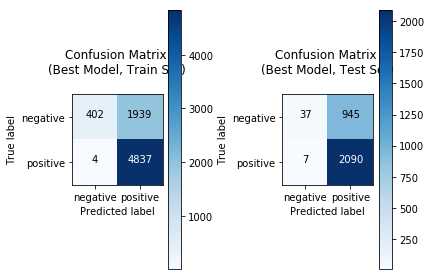

It is 1~ 2
and feature is  10000

Current Model Training Accuracy	: 77.4 %
Current Model Training F1-Score	: 73.4 %
Current Model Testing Accuracy	: 70.9 %
Current Model Testing F1-Score	: 62.9 %


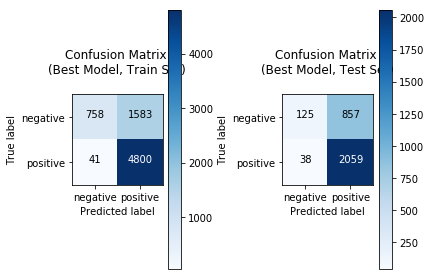

It is 1~ 3
and feature is  10000

Current Model Training Accuracy	: 77.6 %
Current Model Training F1-Score	: 73.8 %
Current Model Testing Accuracy	: 71.1 %
Current Model Testing F1-Score	: 63.3 %


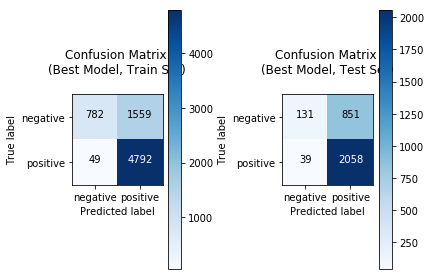

It is 1~ 1
and feature is  40000

Current Model Training Accuracy	: 68.6 %
Current Model Training F1-Score	: 57.0 %
Current Model Testing Accuracy	: 68.1 %
Current Model Testing F1-Score	: 55.3 %


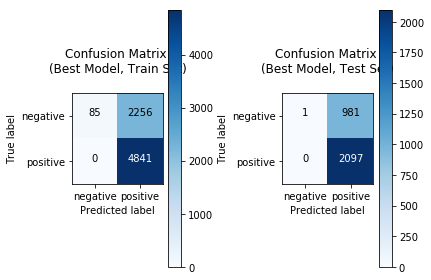

It is 1~ 2
and feature is  40000

Current Model Training Accuracy	: 70.7 %
Current Model Training F1-Score	: 61.4 %
Current Model Testing Accuracy	: 68.5 %
Current Model Testing F1-Score	: 56.0 %


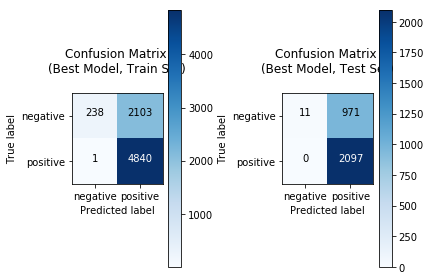

It is 1~ 3
and feature is  40000

Current Model Training Accuracy	: 71.7 %
Current Model Training F1-Score	: 63.3 %
Current Model Testing Accuracy	: 68.6 %
Current Model Testing F1-Score	: 56.4 %


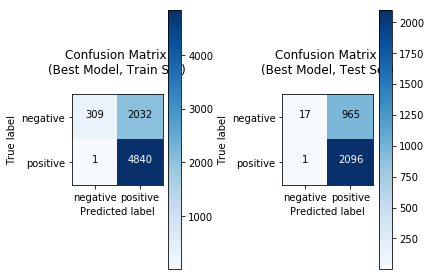

In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.reviewText[0:100000],
                                                    scorePreprocessor(df.overall[0:100000]),
                                                    test_size=0.3,
                                                    random_state=13)

# print(y_train, y_test)
print(len(x_train),len(x_train),len(x_test),len(y_test))

X_train = preprocessing_neg_tag(x_train)
X_test = preprocessing_neg_tag(x_test)

# after neg tag

for i in [10000,40000]:
    for j in range(3):
        X_train_features, X_test_features = vectorizer(X_train, X_test, j+1, i)
        model_list = build_models(X_train_features, y_train, X_test_features, y_test)
        plotandprintResult(model_list, j+1, i)

### Second Model RNN+LSTM
- In this model, the feature is derived from a sentiment lexicon

In [30]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
import numpy as np
from afinn import Afinn

X_train = df.reviewText[:10000]
y_train = df.overall[:10000]
X_test = df.reviewText[10001:13000]
y_test = df.overall[10001:13000]

In [31]:
tokenizer_obj = Tokenizer()
total_reviews = np.concatenate((X_train, X_test), axis=0)
# delete all the number 
total_reviews = preprocessing_neg_tag(total_reviews)
tokenizer_obj.fit_on_texts(total_reviews) 

# pad sequences
max_length = max([len(s.split()) for s in total_reviews])
# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens =  tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)


X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

In [32]:
print(vocab_size)

34227


In [33]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

EMBEDDING_DIM = 100

print('Build model...')

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...
Summary of the built model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1993, 100)         3422700   
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 3,435,501
Trainable params: 3,435,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

print('Train...')

model.fit(X_train_pad, y_train, batch_size=128, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Train...
Train on 10000 samples, validate on 260 samples
Epoch 1/25
 - 284s - loss: -1.7350e+01 - acc: 0.0210 - val_loss: -3.6273e+01 - val_acc: 0.0154
Epoch 2/25


In [ ]:
print('Testing...')
score, acc = model.evaluate(X_test_pad, y_test, batch_size=128)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))